In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z

from sklearn.model_selection import KFold
from astropy.cosmology import FlatLambdaCDM
from astroML import stats as astroMLstats
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import scipy
import corner



from sklearn.model_selection import train_test_split

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,6]

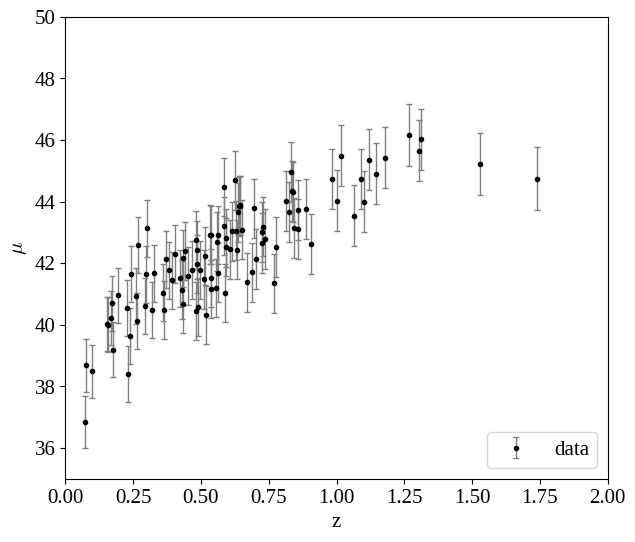

In [79]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

i_ord=z_sample.argsort()

z_sample=z_sample[i_ord]
mu_sample=mu_sample[i_ord]
dmu=dmu[i_ord]

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

z_grid=np.linspace(0.01, 1.9, 100)

kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5))

gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)

gaussian_process.fit(z_sample[:,np.newaxis], mu_sample[:,np.newaxis])
mean_prediction, std_prediction = gaussian_process.predict(z_grid[:,np.newaxis], return_std=True)

print(gaussian_process.kernel_)

30.7**2 * RBF(length_scale=3.9)


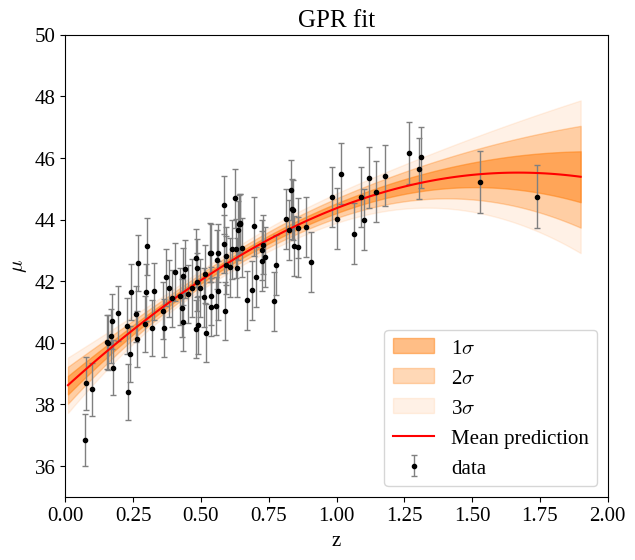

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

plt.fill_between(z_grid.ravel(), mean_prediction - 1 * std_prediction, 
    mean_prediction + 1 * std_prediction, color="tab:orange", alpha=0.5, label='1$\sigma$')
plt.fill_between(z_grid.ravel(), mean_prediction - 2 * std_prediction, 
    mean_prediction + 2 * std_prediction, color="tab:orange", alpha=0.3, label='2$\sigma$')
plt.fill_between(z_grid.ravel(), mean_prediction - 3 * std_prediction, 
    mean_prediction + 3 * std_prediction, color="tab:orange", alpha=0.1, label='3$\sigma$')

plt.plot(z_grid, mean_prediction, label="Mean prediction", c='red')

plt.title('GPR fit')
plt.legend(loc='lower right')
plt.show()

In [5]:
# Model
def model(par, z):
    H0, Om = par
    
    # Flat universe model
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted

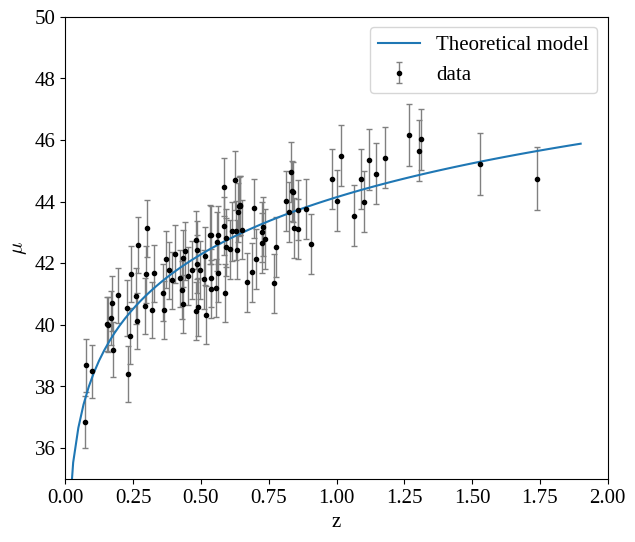

In [110]:
# Theoretical model
zgrid = np.linspace(0.01,1.9,100)
p0 = [70, 0.27]
mu_model = model(p0, zgrid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

plt.plot(zgrid, mu_model, c='C0', label='Theoretical model')

plt.legend()
plt.show()

In [10]:
# try to use nested sampling to obtain the parameters

ndim=2

def prior(u):         
    H0 = u[0]*300         
    Om = u[1]  
    
    par = np.array([H0,Om])   
    return(par)

def loglike(par):
    mufit = model(par, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2)) 

In [11]:
sampler = dynesty.NestedSampler(loglike, prior, ndim)
sampler.run_nested()
result = sampler.results

2400it [00:17, 134.02it/s, +500 | bound: 3 | nc: 1 | ncall: 19659 | eff(%): 15.136 | loglstar:   -inf < -46.388 <    inf | logz: -50.325 +/-  0.072 | dlogz:  0.001 >  0.509]


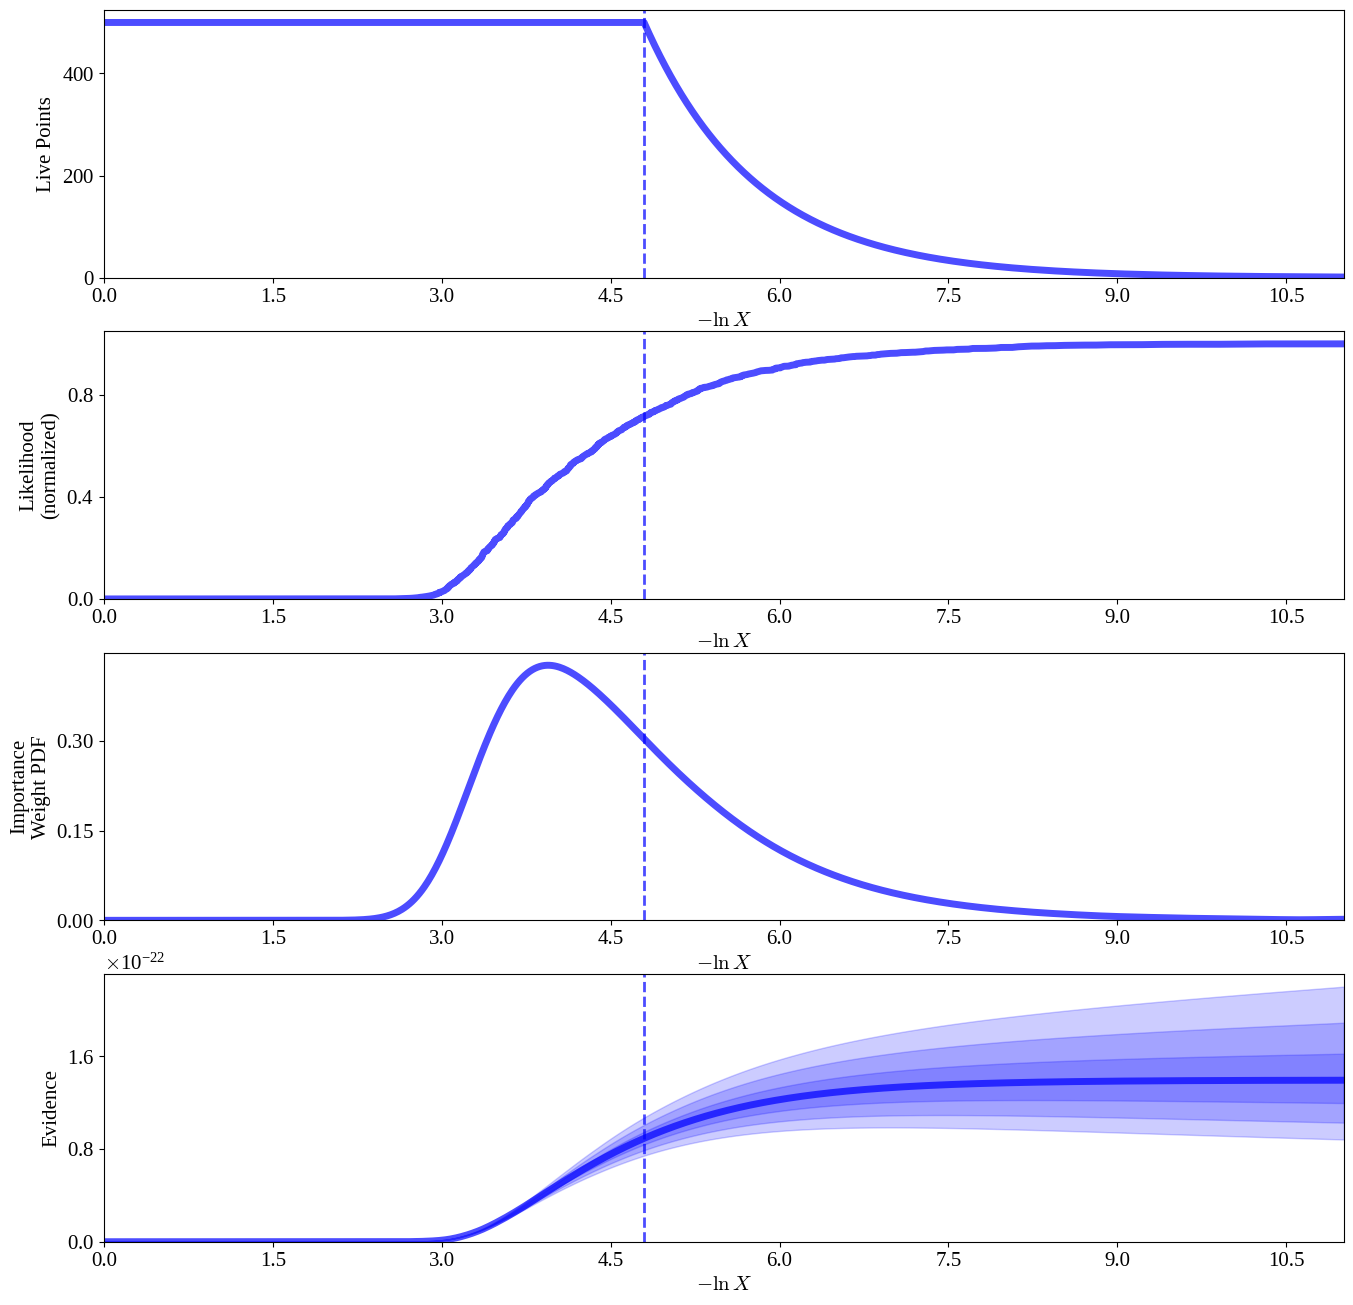

In [12]:
rfig, raxes = dyplot.runplot(result)

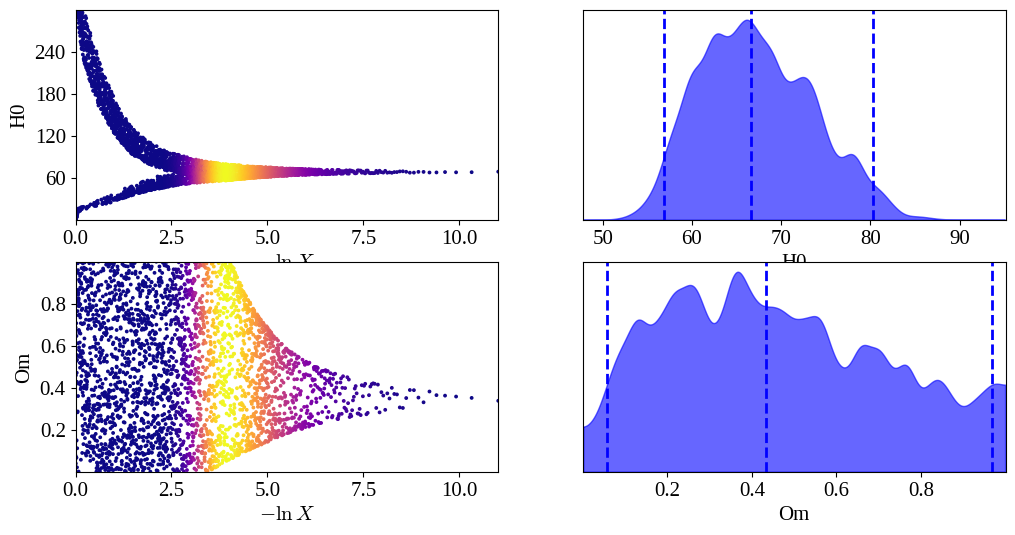

In [13]:
labels = ["H0","Om"]

tfig, taxes = dyplot.traceplot(result, labels=labels)

In [14]:
samples = result.samples
weights = np.exp(result.logwt - result.logz[-1])

samples_eq = dyfunc.resample_equal(samples, weights)

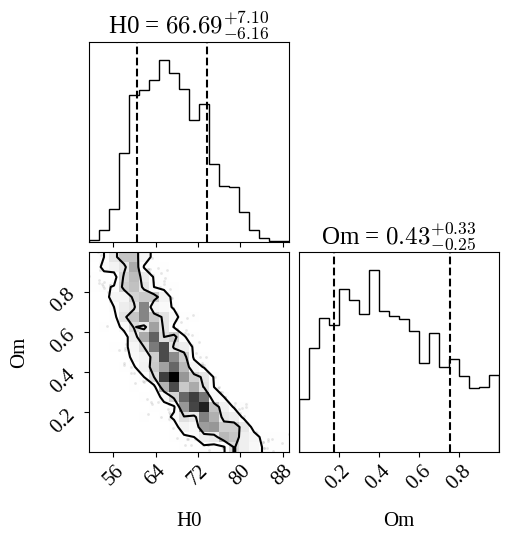

In [15]:
fig = corner.corner(samples_eq, labels=labels, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [16]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

H0 = 66.63 + 11.79 - 8.83
Om = 0.43 + 0.49 - 0.35


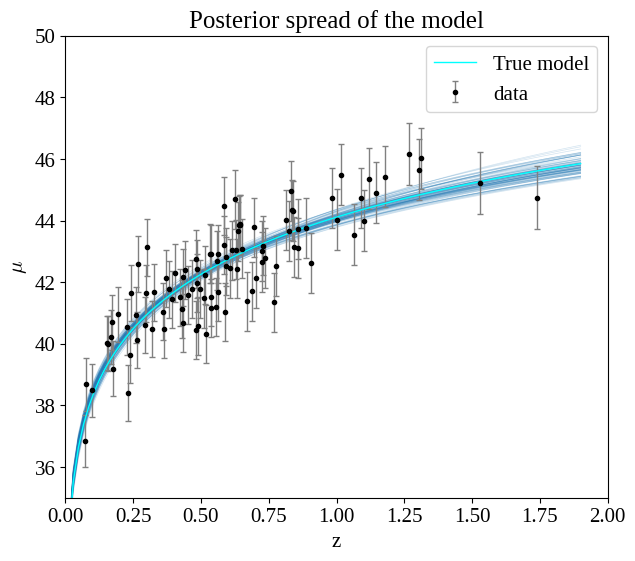

In [107]:
sample100 = samples_eq[np.random.choice(range(len(samples_eq)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for H0, Om in sample100:
    par = [H0, Om]
    model_spread = model(par, zgrid)
    plt.plot(zgrid, model_spread, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

In [31]:
# Model

ndim_noDM=1

def model_noDM(H0, Om, z):
    cosmo = FlatLambdaCDM(H0=H0, Om0=1)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


def prior_noDM(u):
    H0 = u[0]*300  
    
    par = np.array([H0])   
    return(par)


def loglike_noDM(par):

    H0 = float(par)    
    Om=1
    mufit = model_noDM(H0, Om, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2))

In [37]:
sampler_noDM = dynesty.NestedSampler(loglike_noDM, prior_noDM, ndim_noDM)
sampler_noDM.run_nested()
result_noDM = sampler_noDM.results

2354it [00:15, 150.36it/s, +500 | bound: 2 | nc: 1 | ncall: 19221 | eff(%): 15.245 | loglstar:   -inf < -47.102 <    inf | logz: -50.902 +/-  0.067 | dlogz:  0.001 >  0.509]


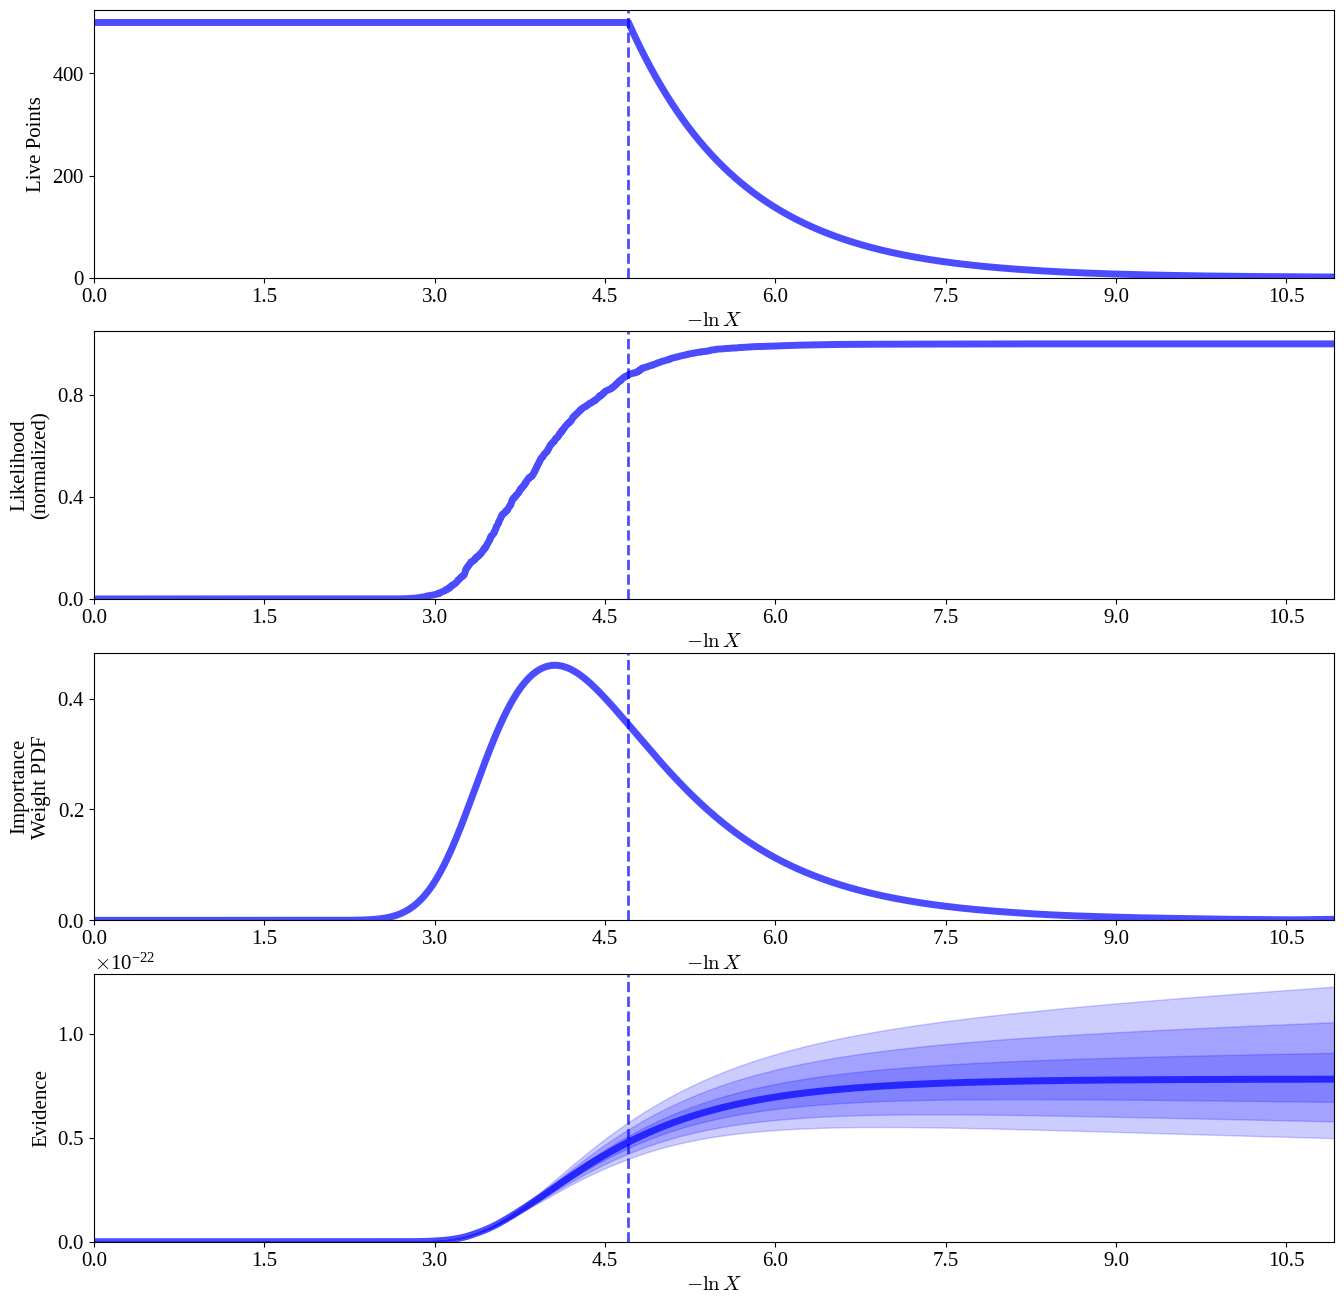

In [38]:
rfig, raxes = dyplot.runplot(result_noDM)

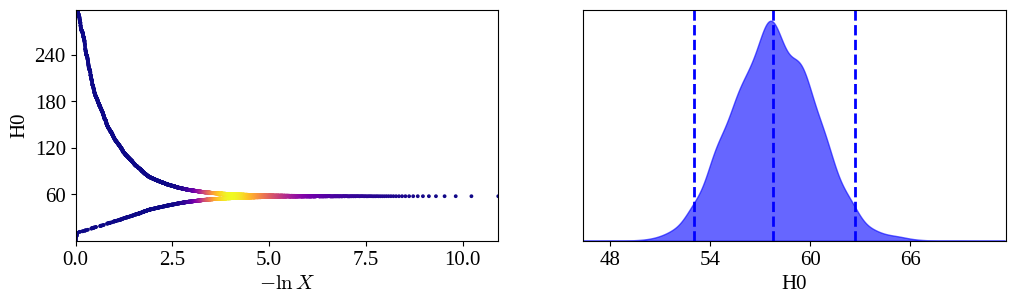

In [39]:
labels_noDM = ["H0"]

tfig, taxes = dyplot.traceplot(result_noDM, labels=labels_noDM)

In [40]:
samples_noDM = result_noDM.samples
weights_noDM = np.exp(result_noDM.logwt - result_noDM.logz[-1])

samples_eq_noDM = dyfunc.resample_equal(samples_noDM, weights_noDM)

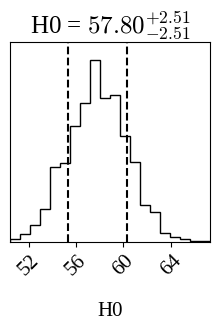

In [41]:
fig = corner.corner(samples_eq_noDM, labels=labels_noDM, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [42]:
quantiles_noDM = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_noDM)
             for samps in samples_noDM.T]
for q,l in zip(quantiles_noDM,labels_noDM):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

H0 = 57.78 + 4.15 - 3.98


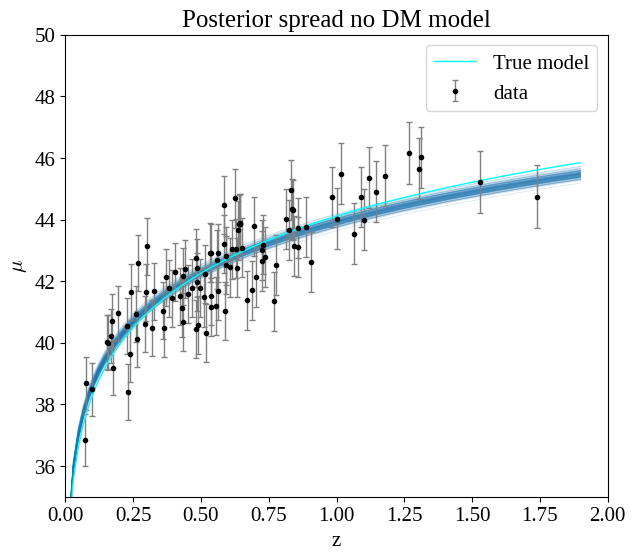

In [106]:
sample100_noDM = samples_eq_noDM[np.random.choice(range(len(samples_eq_noDM)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for H0 in sample100_noDM:
    model_spread_noDM = model_noDM(float(H0), 1, zgrid)
    plt.plot(zgrid, model_spread_noDM, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread no DM model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

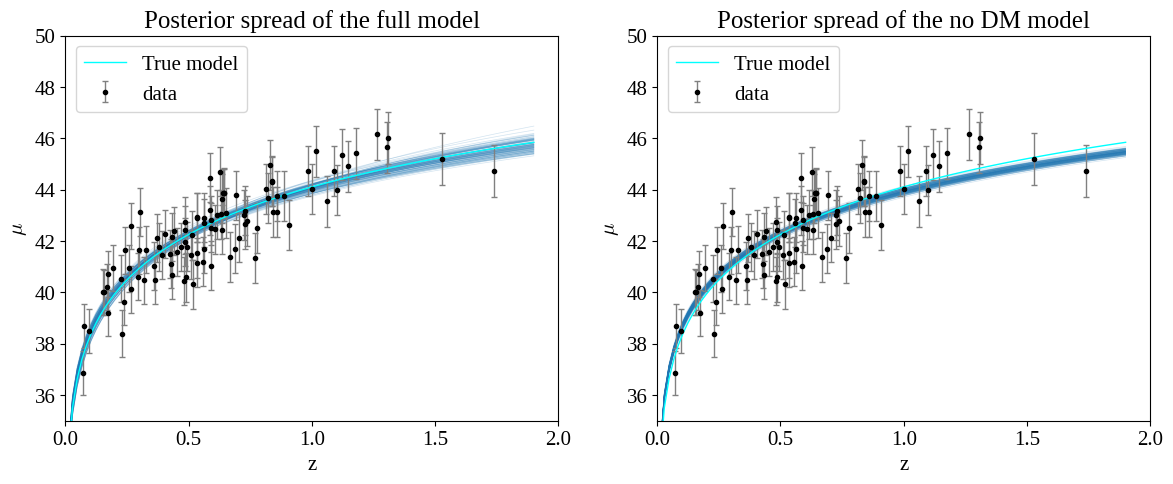

In [63]:
#compare the two models

true_model = model(p0, zgrid)

fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)

for H0, Om in sample100:
    par = [H0, Om]
    model_spread = model(par, zgrid)
    plt.plot(zgrid, model_spread, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the full model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')

plt.legend()

ax = fig.add_subplot(122)

for H0 in sample100_noDM:
    model_spread_noDM = model_noDM(float(H0), 1, zgrid)
    plt.plot(zgrid, model_spread_noDM, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the no DM model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

In [58]:
evidence = np.exp(result.logz[-1])
evidence_noDM = np.exp(result_noDM.logz[-1])

Bayes_factor = evidence/evidence_noDM

print(Bayes_factor)

#the Bayes factor is nearly eqaul to 1

1.78000910495674


In [89]:
#let's imagine that we measured H0=70km/(s*Mpc) and we want to infer the value of Om

# Model

ndim_H0=1

def model_H0(H0, Om, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


def prior_H0(u):
    Om = u[0]  
    
    par = np.array([Om])   
    return(par)


def loglike_H0(par):

    H0 = 70
    Om = float(par) 
    mufit = model_H0(H0, Om, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2))

In [90]:
sampler_H0 = dynesty.NestedSampler(loglike_H0, prior_H0, ndim_H0)
sampler_H0.run_nested()
result_H0 = sampler_H0.results

1089it [00:03, 274.91it/s, +500 | bound: 0 | nc: 1 | ncall: 5174 | eff(%): 33.997 | loglstar:   -inf < -46.399 <    inf | logz: -47.675 +/-    nan | dlogz:  0.001 >  0.509]


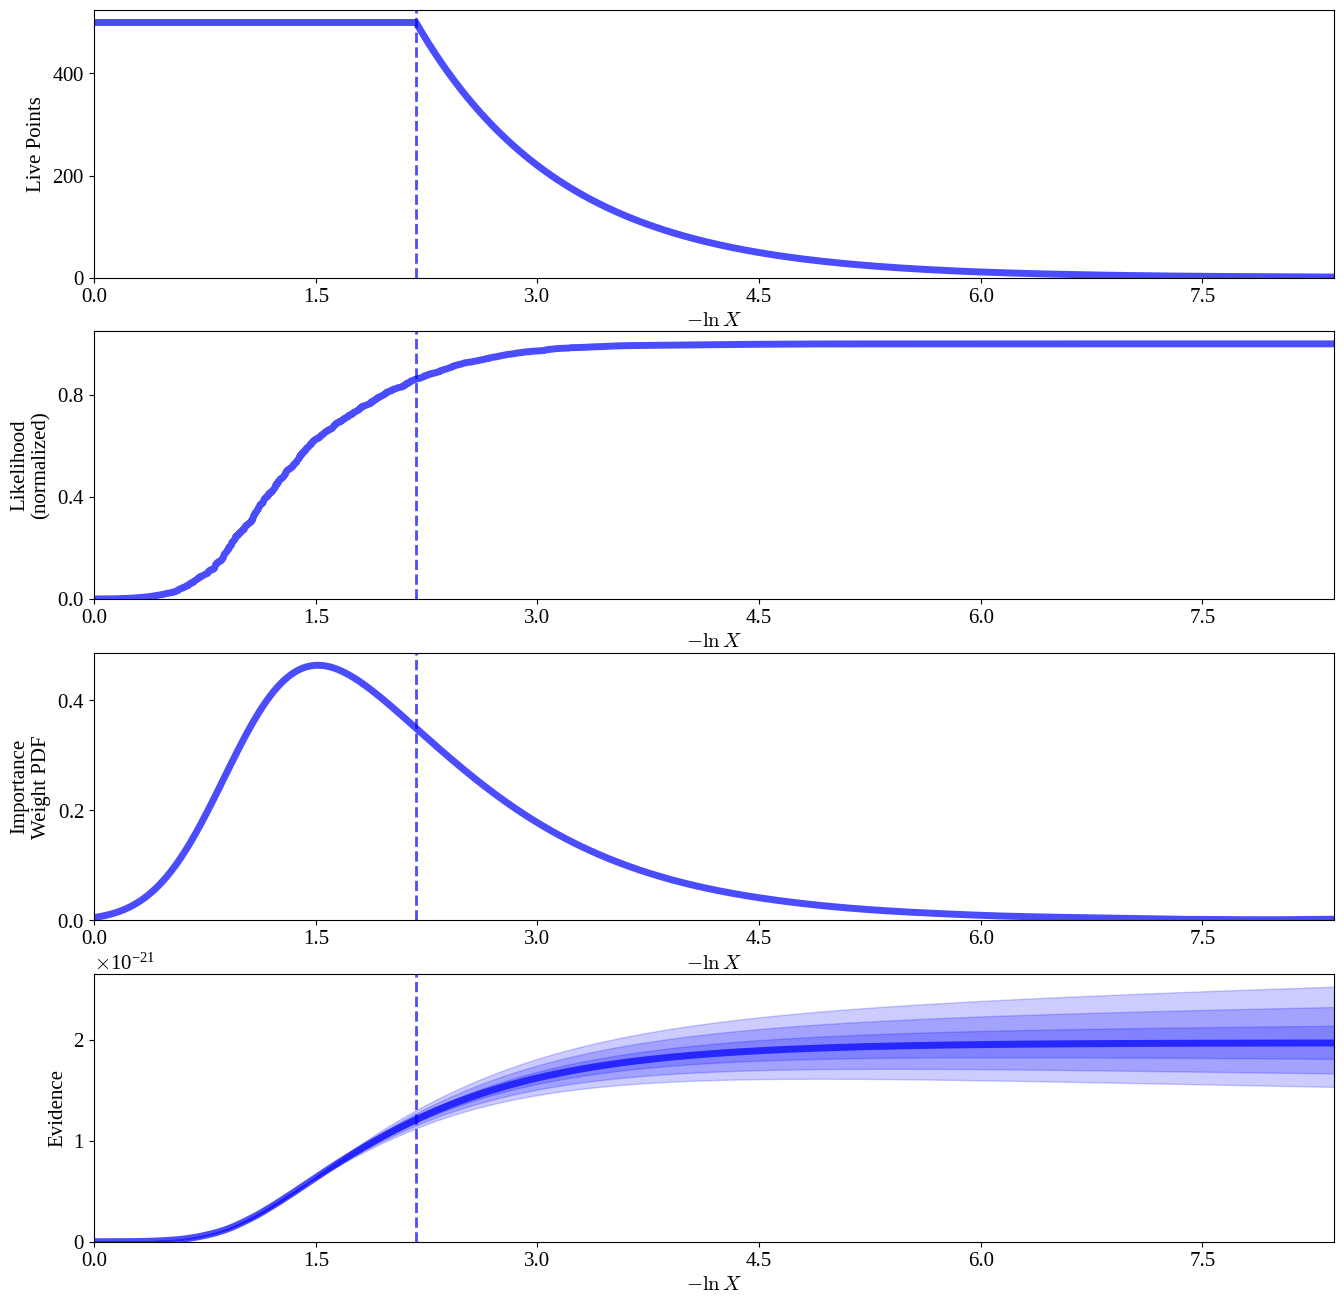

In [91]:
rfig, raxes = dyplot.runplot(result_H0)

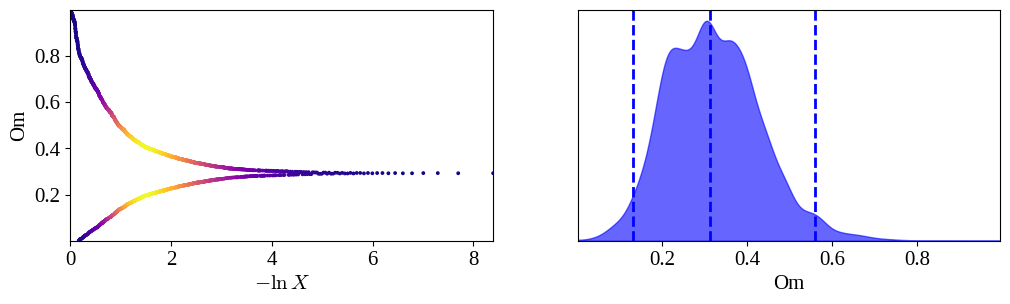

In [93]:
labels_H0 = ["Om"]

tfig, taxes = dyplot.traceplot(result_H0, labels=labels_H0)

In [96]:
samples_H0 = result_H0.samples
weights_H0 = np.exp(result_H0.logwt - result_H0.logz[-1])

samples_eq_H0 = dyfunc.resample_equal(samples_H0, weights_H0)

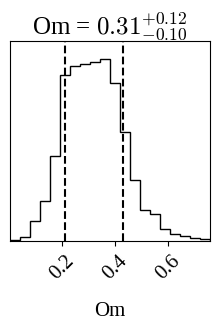

In [97]:
fig = corner.corner(samples_eq_H0, labels=labels_H0, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [98]:
quantiles_H0 = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_H0)
             for samps in samples_H0.T]
for q,l in zip(quantiles_H0,labels_H0):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

Om = 0.31 + 0.19 - 0.16


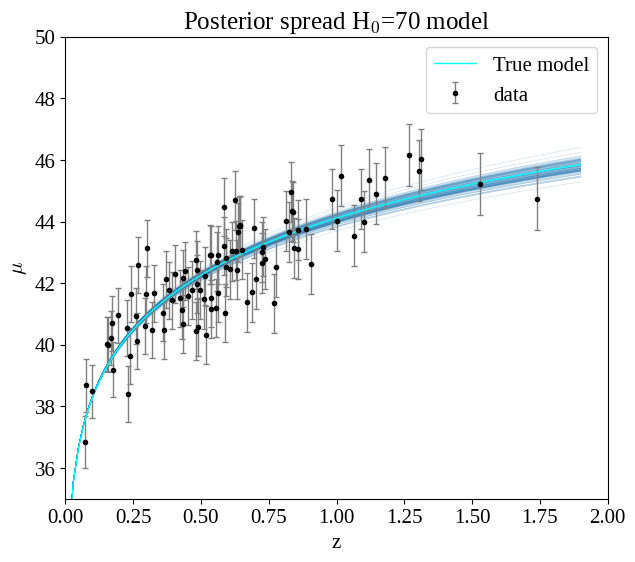

In [105]:
sample100_H0 = samples_eq_H0[np.random.choice(range(len(samples_eq_H0)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for Om in sample100_H0:
    model_spread_H0 = model_H0(70, float(Om), zgrid)
    plt.plot(zgrid, model_spread_H0, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread H$_0$=70 model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

In [87]:
#clone some data

N=1000

z_clone=np.random.uniform(0,2,N)
mu_model=[]
mu_gpr=[]
for z in z_clone:
    par = samples_eq[np.random.choice(samples_eq.shape[0])]
    mu_model.append(model(par, z))
    
    mu_fit, sigma = gaussian_process.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

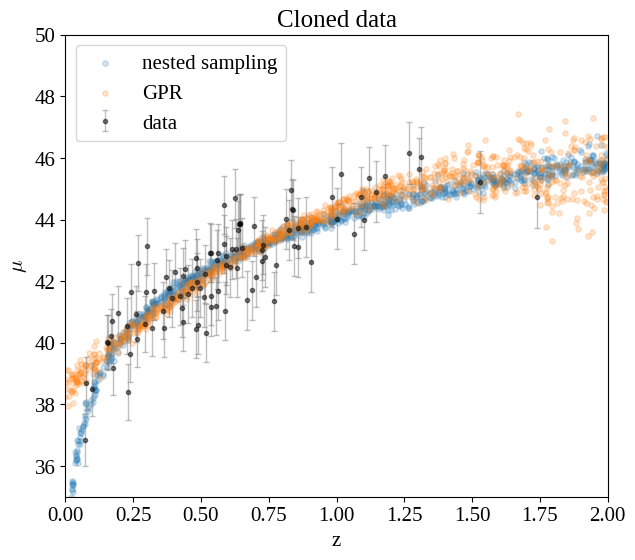

In [88]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.5, label='data')

plt.scatter(z_clone,mu_model,alpha=0.2, s=15,label="nested sampling")
plt.scatter(z_clone,mu_gpr,alpha=0.2, s=15, label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend(loc='upper left')
plt.show()